# Lab 9a: PCA for Face Recognition
    
Following the demo for this unit, we will explore further the use of PCA for feature dimension reduction for classification. We will use a 2-layer neural net on the PCA coefficients. We will practice optimizing the classificaiton parameters (the number of PCA components and the number of hidden nodes in the NN classifier). We will furthermore compare this approach with using convolutional neural net on raw images.

Through the lab, you will learn to:

* Perform PCA on the a face dataset to find the PC components
* Evaluate the effect of using different nubmer of principle components for data representation and classification.
* Optimize the number of PC coefficients and classifier parameters together to maximize classification accuracy.
* Understand the impact of training data size on the feature and classification method selection.


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Import the flw_people dataset. 
# Select only those people with at least 100 instances 
# Reduce the face image size by 0.4

# TO DO
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)

In [4]:
# Save the face images in a datamatrix X and the labels and corresponding names in a datamatrix y and target_names
# Furthermore, determine the number of samples and the image size 
# Determine the number of different faces (number of classes)

# TO DO
n_samples, h, w = lfw_people.images.shape
npix = h*w
# Data in 2D form
X = lfw_people.data
n_features = X.shape[1]
# Labels of images
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Image size = {0:d} x {1:d} = {2:d} pixels".format(h,w,npix)) 
print("Number faces = {0:d}".format(n_samples))
print("Number classes = {0:d}".format(n_classes))

Image size = 50 x 37 = 1850 pixels
Number faces = 1140
Number classes = 5


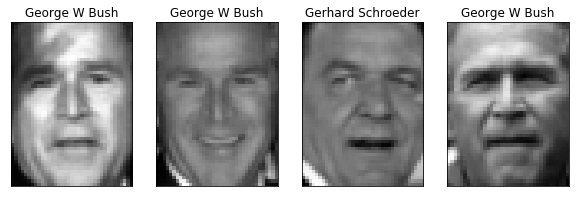

In [6]:
# Plot some sample images to make sure your data load is correct
def plt_face(x):
    h = 50
    w = 37
    plt.imshow(x.reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
I = np.random.permutation(n_samples) 
plt.figure(figsize=(10,20))
nplt = 4;
for i in range(nplt):
    ind = I[i]
    plt.subplot(1,nplt,i+1)
    plt_face(X[ind])
    plt.title(target_names[y[ind]])

In [7]:
# Split the data into a training set and test set with 50% data for training. 
# Use "stratify" option to make sure the training data and test data have same 
# proportion of images from different faces
# print the number of samples in the training data

# TO DO 
from sklearn.model_selection import train_test_split 
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y,test_size=0.5)

n_samples_train = X_train.shape[0]
print("Number faces in training data = {0:d}".format(n_samples_train))

Number faces in training data = 570


In [8]:
# Perfom PCA on the training data to derive the principle components (PCs) and the PCA coefficients 
# You can directly use the PCA class in PCA package or use SVD.
# Remember that you need to remove the mean from the data first
# Also you should rescale the PCs so that the PCA coefficients all have unit variance
# Determine the total number of PCs

# TO DO 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
n_samples, _ = X_train.shape
Xtr_mean = np.mean(X_train,0)
Xtr = X_train - Xtr_mean[None,:]
Utr,Str,Vtr = np.linalg.svd(Xtr, full_matrices=False)
print("The total number of PCs is %d." % Vtr.shape[0])

The total number of PCs is 570.


First let us construct a 2-layer neural net classifier that uses npc= 100 PCA coefficients to classify the faces.  Set up your training and testing data to contain npc PCA coefficients using the previously determined principle components. You should directly use matrix multiplication (i.e. projecting original data to the first 100 principle components you found previously) to find the coefficients rather then using the pca.transform( ) method.


In [10]:
# TO DO
npc = 100
eigenface = Vtr[:npc,:]
Xtr_pca = Xtr.dot(eigenface.T)
Xtr_pca_s = Xtr_pca / Str[None,:npc] * np.sqrt(n_samples) 
Xts = X_test - Xtr_mean[None,:]
Xts_pca = Xts.dot(eigenface.T)
Xts_pca_s = Xts_pca / Str[None,:npc] * np.sqrt(n_samples)

Now set up and compile a NN model with number of hidden nodes nnode=100 and a output layer, and then fit the model to the training data. Use 'relu' for the activation for the hidden layer and use 'softmax' for the output layer. Using `sparse_categorical_crossentropy` for the loss. Use `accuracy` as the metrics. You can choose to do a small number of epochs (=10) with batch size =100.  Determine the accuracy on the validation set.

In [15]:
# TO DO
import keras
from keras.models import Model, Sequential 
from keras.layers import Dense, Activation 
from keras.layers import Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D 
import keras.backend as K
K.clear_session()
nin = Xtr_pca.shape[1] # dimension of input data 
nh = 100 # number of hidden units
nout = int(np.max(y_train)+1) # number of outputs 
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='relu', name='hidden'))
model.add(Dense(nout, activation='softmax', name='output'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 5)                 505       
Total params: 10,605
Trainable params: 10,605
Non-trainable params: 0
_________________________________________________________________


Now try to identify the best number of PCs and the best number of hidden nodes in the NN classifer that can achieve the highest validation accuracy. 
You can set the range of PCs and nubmer of hidden nodes as below.

nnodes = [50,100,150,200, 250],
npcs = [50,100,150,200]


In [17]:
# Set up an array to store accuracy for different nnode and npcs
# TO DO
from keras import optimizers
opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) 
model.compile(optimizer=opt,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
hist = model.fit(Xtr_pca_s, y_train, epochs=10, batch_size=100)

nnodes = [50,100,150,200,250]
npcs = [50,100,150,200]

Epoch 1/10
570/570 [==============================] - 0s 376us/step - loss: 0.0086 - acc: 0.9982
Epoch 2/10
570/570 [==============================] - 0s 35us/step - loss: 0.0031 - acc: 1.0000
Epoch 3/10
570/570 [==============================] - 0s 35us/step - loss: 0.0014 - acc: 1.0000
Epoch 4/10
570/570 [==============================] - 0s 38us/step - loss: 8.5248e-04 - acc: 1.0000
Epoch 5/10
570/570 [==============================] - 0s 34us/step - loss: 4.0785e-04 - acc: 1.0000
Epoch 6/10
570/570 [==============================] - 0s 30us/step - loss: 2.4188e-04 - acc: 1.0000
Epoch 7/10
570/570 [==============================] - 0s 30us/step - loss: 1.5982e-04 - acc: 1.0000
Epoch 8/10
570/570 [==============================] - 0s 36us/step - loss: 1.1410e-04 - acc: 1.0000
Epoch 9/10
570/570 [==============================] - 0s 26us/step - loss: 8.8744e-05 - acc: 1.0000
Epoch 10/10
570/570 [==============================] - 0s 34us/step - loss: 7.2105e-05 - acc: 1.0000


In [19]:
# Loop through the combinations to find the accuracy for each combination
# For each possible combination of `nnode` and `npc`, set up and fit the model 
# using features containing only coefficents corresponding to npc coefficients.

# TO DO 
result = np.zeros((len(npcs),len(nnodes)))
loss_hist = []
train_acc_hist = []
val_acc_hist = []
for i,npc in enumerate(npcs):
    for j,nnode in enumerate(nnodes):
        K.clear_session()
        eigenface = Vtr[:npc,:]
        Xtr_pca = X_train.dot(eigenface.T)
        Xtr_pca_s = Xtr_pca / Str[None,:npc] * np.sqrt(n_samples) 
        Xts = X_test - Xtr_mean[None,:]
        Xts_pca = Xts.dot(eigenface.T)
        Xts_pca_s = Xts_pca / Str[None,:npc] * np.sqrt(n_samples)
        nin = Xtr_pca.shape[1] # dimension of input data
        nh = nnode # number of hidden units
        nout = int(np.max(y_train)+1)
        model = Sequential()
        model.add(Dense(nh, input_shape=(nin,), activation='relu', name='hidden')) 
        model.add(Dense(nout, activation='softmax', name='output'))
        opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0) 
        model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
        hist = model.fit(Xtr_pca_s, y_train, epochs=10, batch_size=100,
                         validation_data=(Xts_pca_s, y_test),shuffle=True) 
        result[i][j] = hist.history['val_acc'][-1]

Train on 570 samples, validate on 570 samples
Epoch 1/10
570/570 [==============================] - 0s 363us/step - loss: 1.5764 - acc: 0.4175 - val_loss: 1.4764 - val_acc: 0.4123
Epoch 2/10
570/570 [==============================] - 0s 36us/step - loss: 1.0512 - acc: 0.6263 - val_loss: 1.2468 - val_acc: 0.5421
Epoch 3/10
570/570 [==============================] - 0s 44us/step - loss: 0.7170 - acc: 0.7877 - val_loss: 1.0887 - val_acc: 0.6140
Epoch 4/10
570/570 [==============================] - 0s 45us/step - loss: 0.5308 - acc: 0.8491 - val_loss: 0.9990 - val_acc: 0.6316
Epoch 5/10
570/570 [==============================] - 0s 43us/step - loss: 0.3848 - acc: 0.8877 - val_loss: 0.8993 - val_acc: 0.6842
Epoch 6/10
570/570 [==============================] - 0s 34us/step - loss: 0.3033 - acc: 0.9158 - val_loss: 0.8786 - val_acc: 0.6895
Epoch 7/10
570/570 [==============================] - 0s 39us/step - loss: 0.2402 - acc: 0.9368 - val_loss: 0.8422 - val_acc: 0.7123
Epoch 8/10
570/570 [==

570/570 [==============================] - 0s 44us/step - loss: 0.0440 - acc: 0.9947 - val_loss: 0.9487 - val_acc: 0.6877
Train on 570 samples, validate on 570 samples
Epoch 1/10
570/570 [==============================] - 0s 364us/step - loss: 1.5875 - acc: 0.4667 - val_loss: 1.1933 - val_acc: 0.6053
Epoch 2/10
570/570 [==============================] - 0s 38us/step - loss: 0.7907 - acc: 0.7544 - val_loss: 0.9521 - val_acc: 0.7018
Epoch 3/10
570/570 [==============================] - 0s 50us/step - loss: 0.3971 - acc: 0.8982 - val_loss: 0.8306 - val_acc: 0.7281
Epoch 4/10
570/570 [==============================] - 0s 55us/step - loss: 0.2126 - acc: 0.9596 - val_loss: 0.7588 - val_acc: 0.7456
Epoch 5/10
570/570 [==============================] - 0s 75us/step - loss: 0.1167 - acc: 0.9877 - val_loss: 0.7298 - val_acc: 0.7561
Epoch 6/10
570/570 [==============================] - 0s 63us/step - loss: 0.0722 - acc: 0.9912 - val_loss: 0.7262 - val_acc: 0.7719
Epoch 7/10
570/570 [=============

570/570 [==============================] - 0s 44us/step - loss: 0.0159 - acc: 1.0000 - val_loss: 0.8427 - val_acc: 0.7298
Epoch 10/10
570/570 [==============================] - 0s 45us/step - loss: 0.0113 - acc: 1.0000 - val_loss: 0.8470 - val_acc: 0.7421
Train on 570 samples, validate on 570 samples
Epoch 1/10
570/570 [==============================] - 0s 387us/step - loss: 2.4614 - acc: 0.3965 - val_loss: 1.4814 - val_acc: 0.4123
Epoch 2/10
570/570 [==============================] - 0s 41us/step - loss: 1.0770 - acc: 0.6895 - val_loss: 1.1959 - val_acc: 0.5649
Epoch 3/10
570/570 [==============================] - 0s 49us/step - loss: 0.6413 - acc: 0.8351 - val_loss: 1.0752 - val_acc: 0.6140
Epoch 4/10
570/570 [==============================] - 0s 49us/step - loss: 0.4009 - acc: 0.9070 - val_loss: 0.9634 - val_acc: 0.6754
Epoch 5/10
570/570 [==============================] - 0s 48us/step - loss: 0.2585 - acc: 0.9193 - val_loss: 0.9708 - val_acc: 0.6737
Epoch 6/10
570/570 [============

570/570 [==============================] - 0s 42us/step - loss: 0.0110 - acc: 1.0000 - val_loss: 0.9255 - val_acc: 0.7175
Epoch 9/10
570/570 [==============================] - 0s 147us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.9596 - val_acc: 0.7105
Epoch 10/10
570/570 [==============================] - 0s 53us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.9670 - val_acc: 0.7211
Train on 570 samples, validate on 570 samples
Epoch 1/10
570/570 [==============================] - 0s 477us/step - loss: 2.5762 - acc: 0.3632 - val_loss: 1.6685 - val_acc: 0.3228
Epoch 2/10
570/570 [==============================] - 0s 46us/step - loss: 1.0014 - acc: 0.6456 - val_loss: 1.5409 - val_acc: 0.3842
Epoch 3/10
570/570 [==============================] - 0s 58us/step - loss: 0.6294 - acc: 0.8123 - val_loss: 1.5791 - val_acc: 0.4386
Epoch 4/10
570/570 [==============================] - 0s 54us/step - loss: 0.3459 - acc: 0.9035 - val_loss: 1.4684 - val_acc: 0.5246
Epoch 5/10
570/570 [===========

In [30]:
# Determine the npc and nnode that provides the highest validation accuracy 
# TO DO 
highest_accuracy = result[0][0] 
opt_npc_index = 0
opt_nnode_index = 0
for i in range(0,len(npcs)):
    for j in range(0,len(nnodes)):
        if result[i][j] > highest_accuracy:
            highest_accuracy = result[i][j]
            opt_npc_index = i
            opt_nnode_index = j
print("The best npc is %d, and the best nnode is %d." % (npcs[opt_npc_index],nnodes[opt_nnode_index]))
print("The best validation accuracy is %f." % highest_accuracy)

The best npc is 50, and the best nnode is 250.
The best validation accuracy is 0.792982.


Text(0,0.5,'npcs')

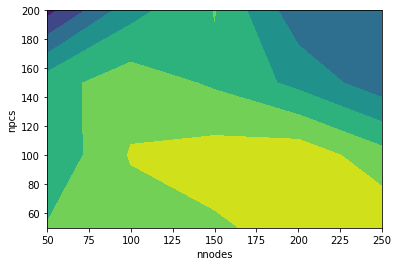

In [31]:
# Produce a contour plot of the accuracy using different nnode and npc combincations
# TO DO

# plt.contourf ...
grid_x, grid_y = np.mgrid[50:250:50, 50:300:50] 
plt.contourf(grid_y,grid_x,result)
plt.xlabel("nnodes")
plt.ylabel("npcs")

## Now let us compare the PCA+NN with applying a CNN on the raw image data only. 

Note that you should scale your image data to between 0 and 1. And you should reshape your training and testing data according to image width and height


In [35]:
# Data preparation for input to CNN
# TO DO
Xtr_cnn = X_train.astype("float32")/255
Xts_cnn = X_test.astype("float32")/255
Xtr_cnn = np.reshape(Xtr_cnn, (len(Xtr_cnn),h,w,1))
Xts_cnn = np.reshape(Xts_cnn, (len(X)-len(Xtr_cnn),h,w,1))

In [36]:
# Set up a CNN model
# You can use 2 conv2D layer, each with kernel size of 5x5, each followed by a pooling layer with strides of 2
# For this part, let both conv2D layer generate 16 channels. 
# The Conv layer should be followed by a flatten layer and two dense layers. 
# The first dense layer should produce 200 outputs. 
# The last dense layer is the output layer with n_classes output using 'softmax' activation.
# Print model summary to verify it follows the desired structure and compile the model

# TO DO 
model = Sequential()
model.add(Conv2D(16, (5, 5),
                 padding='valid',
                 input_shape=Xtr_cnn.shape[1:],
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5, 5), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(200, activation='relu')) 
model.add(Dense(nout, activation='softmax')) # TO DO
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 33, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 12, 16)        6416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 864)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               173000    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1005      
Total para

In [37]:
# Fit the model using batch size=100, epochs = 40
# Print the accuracy on the validation set

# TO DO 
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) 
# Let's train the model using Adam
model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=opt,metrics=['accuracy'])
hist_basic = model.fit(Xtr_cnn, y_train,batch_size=100,epochs=40,
                       validation_data=(Xts_cnn, y_test),shuffle=True) 
print("The accuracy on validation set is:")
print(hist_basic.history['val_acc'])

Train on 570 samples, validate on 570 samples
Epoch 1/40
570/570 [==============================] - 2s 3ms/step - loss: 1.4842 - acc: 0.3877 - val_loss: 1.3951 - val_acc: 0.4649
Epoch 2/40
570/570 [==============================] - 1s 3ms/step - loss: 1.3941 - acc: 0.4649 - val_loss: 1.3807 - val_acc: 0.4649
Epoch 3/40
570/570 [==============================] - 2s 3ms/step - loss: 1.3714 - acc: 0.4649 - val_loss: 1.3579 - val_acc: 0.4649
Epoch 4/40
570/570 [==============================] - 1s 3ms/step - loss: 1.3443 - acc: 0.4649 - val_loss: 1.3325 - val_acc: 0.4649
Epoch 5/40
570/570 [==============================] - 1s 3ms/step - loss: 1.3016 - acc: 0.4912 - val_loss: 1.2861 - val_acc: 0.4684
Epoch 6/40
570/570 [==============================] - 2s 3ms/step - loss: 1.2390 - acc: 0.5000 - val_loss: 1.2291 - val_acc: 0.5404
Epoch 7/40
570/570 [==============================] - 2s 3ms/step - loss: 1.1645 - acc: 0.5579 - val_loss: 1.1554 - val_acc: 0.5579
Epoch 8/40
570/570 [==========

How do the result compared with the PCA+NN method? (If you did right, they should be similar, with PCA+NN being slightly better. If you used more training data (e.g. 75%) and you trained the CNN with more epochs, CNN method may get better). 

A: PCA+NN method is slightly better with validation accuracy around 0.83, CNN method is with validation accuracy around 0.79.


## Repeat the above using a small dataset

Instead of using 50% of the total data for training, let us assume you have only 10% of the total data for training. Repeat both the PCA+NN and the CNN method, to see which one gives you better results. 

Note that with only 10% data for training, the range of the npc has to be set to be below the total number of training samples. 

For the CNN model, because you have small number of training samples, you cannot train a network with a large number of parameters reliably. Instead of producing 16 channels for each of the two conv2D layers, configure the model to produce only 8 channels each. 

In [41]:
## TO DO
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y,test_size=0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size=0.9) 
n_samples, _ = X_train.shape
Xtr_mean = np.mean(X_train,0)
Xtr = X_train - Xtr_mean[None,:]
Utr,Str,Vtr = np.linalg.svd(Xtr, full_matrices=False)
nnodes = [50,100,150,200,250]
npcs = [50,60,70,80,90,100]
result = np.zeros((len(npcs),len(nnodes)))
loss_hist = []
train_acc_hist = []
val_acc_hist = []
for i,npc in enumerate(npcs):
    for j,nnode in enumerate(nnodes):
        K.clear_session()
        eigenface = Vtr[:npc,:]
        Xtr_pca = Xtr.dot(eigenface.T)
        Xtr_pca_s = Xtr_pca / Str[None,:npc] * np.sqrt(n_samples) 
        Xts = X_test - Xtr_mean[None,:]
        Xts_pca = Xts.dot(eigenface.T)
        Xts_pca_s = Xts_pca / Str[None,:npc] * np.sqrt(n_samples)
        nin = Xtr_pca.shape[1] # dimension of input data
        nh = nnode # number of hidden units
        nout = int(np.max(y_train)+1)
        model = Sequential()
        model.add(Dense(nh, input_shape=(nin,), activation='relu', name='hidden')) 
        model.add(Dense(nout, activation='softmax', name='output'))
        opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        hist = model.fit(Xtr_pca_s, y_train, epochs=10, batch_size=100,
                         validation_data=(Xts_pca_s, y_test))
        result[i][j] = hist.history['val_acc'][-1]
highest_accuracy = result[0][0] 
opt_npc_index = 0
opt_nnode_index = 0
for i in range(0,len(npcs)):
    for j in range(0,len(nnodes)):
        if result[i][j] > highest_accuracy:
            highest_accuracy = result[i][j]
            opt_npc_index = i
            opt_nnode_index = j
print("The best npc is %d, and the best nnode is %d." % (npcs[opt_npc_index],nnodes[opt_nnode_index]))
print("The best validation accuracy is %f." % highest_accuracy)

Train on 114 samples, validate on 1026 samples
Epoch 1/10
114/114 [==============================] - 0s 2ms/step - loss: 1.6904 - acc: 0.2982 - val_loss: 1.4509 - val_acc: 0.4172
Epoch 2/10
114/114 [==============================] - 0s 198us/step - loss: 1.2262 - acc: 0.5088 - val_loss: 1.3349 - val_acc: 0.4951
Epoch 3/10
114/114 [==============================] - 0s 205us/step - loss: 0.9618 - acc: 0.7018 - val_loss: 1.2358 - val_acc: 0.5585
Epoch 4/10
114/114 [==============================] - 0s 151us/step - loss: 0.7583 - acc: 0.7982 - val_loss: 1.1481 - val_acc: 0.5926
Epoch 5/10
114/114 [==============================] - 0s 205us/step - loss: 0.6010 - acc: 0.8684 - val_loss: 1.0799 - val_acc: 0.6140
Epoch 6/10
114/114 [==============================] - 0s 179us/step - loss: 0.4785 - acc: 0.9211 - val_loss: 1.0265 - val_acc: 0.6287
Epoch 7/10
114/114 [==============================] - 0s 158us/step - loss: 0.3843 - acc: 0.9298 - val_loss: 0.9814 - val_acc: 0.6472
Epoch 8/10
114/11

114/114 [==============================] - 0s 157us/step - loss: 0.1264 - acc: 1.0000 - val_loss: 0.9598 - val_acc: 0.6715
Train on 114 samples, validate on 1026 samples
Epoch 1/10
114/114 [==============================] - 0s 2ms/step - loss: 1.9153 - acc: 0.1930 - val_loss: 1.3261 - val_acc: 0.5136
Epoch 2/10
114/114 [==============================] - 0s 159us/step - loss: 1.0128 - acc: 0.6491 - val_loss: 1.1451 - val_acc: 0.5712
Epoch 3/10
114/114 [==============================] - 0s 184us/step - loss: 0.6759 - acc: 0.7632 - val_loss: 1.0528 - val_acc: 0.6082
Epoch 4/10
114/114 [==============================] - 0s 188us/step - loss: 0.4772 - acc: 0.8333 - val_loss: 0.9669 - val_acc: 0.6394
Epoch 5/10
114/114 [==============================] - 0s 205us/step - loss: 0.3117 - acc: 0.9561 - val_loss: 0.8927 - val_acc: 0.6920
Epoch 6/10
114/114 [==============================] - 0s 188us/step - loss: 0.1990 - acc: 0.9825 - val_loss: 0.8485 - val_acc: 0.6998
Epoch 7/10
114/114 [========

114/114 [==============================] - 0s 143us/step - loss: 0.0324 - acc: 1.0000 - val_loss: 0.9172 - val_acc: 0.6764
Epoch 10/10
114/114 [==============================] - 0s 185us/step - loss: 0.0220 - acc: 1.0000 - val_loss: 0.9207 - val_acc: 0.6842
Train on 114 samples, validate on 1026 samples
Epoch 1/10
114/114 [==============================] - 0s 2ms/step - loss: 1.8350 - acc: 0.1930 - val_loss: 1.2804 - val_acc: 0.5107
Epoch 2/10
114/114 [==============================] - 0s 170us/step - loss: 0.8478 - acc: 0.7105 - val_loss: 1.1431 - val_acc: 0.5673
Epoch 3/10
114/114 [==============================] - 0s 179us/step - loss: 0.5193 - acc: 0.8509 - val_loss: 1.0249 - val_acc: 0.6238
Epoch 4/10
114/114 [==============================] - 0s 183us/step - loss: 0.3003 - acc: 0.9298 - val_loss: 0.9452 - val_acc: 0.6589
Epoch 5/10
114/114 [==============================] - 0s 182us/step - loss: 0.1767 - acc: 0.9825 - val_loss: 0.8972 - val_acc: 0.6832
Epoch 6/10
114/114 [=======

114/114 [==============================] - 0s 179us/step - loss: 0.0181 - acc: 1.0000 - val_loss: 0.9351 - val_acc: 0.7076
Epoch 9/10
114/114 [==============================] - 0s 185us/step - loss: 0.0111 - acc: 1.0000 - val_loss: 0.9532 - val_acc: 0.7086
Epoch 10/10
114/114 [==============================] - 0s 183us/step - loss: 0.0071 - acc: 1.0000 - val_loss: 0.9717 - val_acc: 0.7144
Train on 114 samples, validate on 1026 samples
Epoch 1/10
114/114 [==============================] - 0s 3ms/step - loss: 2.0338 - acc: 0.1491 - val_loss: 1.2148 - val_acc: 0.5497
Epoch 2/10
114/114 [==============================] - 0s 187us/step - loss: 0.7785 - acc: 0.7368 - val_loss: 1.1358 - val_acc: 0.5595
Epoch 3/10
114/114 [==============================] - 0s 185us/step - loss: 0.4785 - acc: 0.7895 - val_loss: 1.0569 - val_acc: 0.6043
Epoch 4/10
114/114 [==============================] - 0s 210us/step - loss: 0.2627 - acc: 0.9474 - val_loss: 0.9653 - val_acc: 0.6511
Epoch 5/10
114/114 [=======

114/114 [==============================] - 0s 253us/step - loss: 0.0174 - acc: 1.0000 - val_loss: 0.8944 - val_acc: 0.7008
Epoch 8/10
114/114 [==============================] - 0s 208us/step - loss: 0.0105 - acc: 1.0000 - val_loss: 0.9111 - val_acc: 0.6969
Epoch 9/10
114/114 [==============================] - 0s 263us/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.9294 - val_acc: 0.6979
Epoch 10/10
114/114 [==============================] - 0s 230us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.9475 - val_acc: 0.6998
Train on 114 samples, validate on 1026 samples
Epoch 1/10
114/114 [==============================] - 0s 2ms/step - loss: 1.8944 - acc: 0.1404 - val_loss: 1.1934 - val_acc: 0.5643
Epoch 2/10
114/114 [==============================] - 0s 197us/step - loss: 0.5178 - acc: 0.8947 - val_loss: 1.0422 - val_acc: 0.6150
Epoch 3/10
114/114 [==============================] - 0s 257us/step - loss: 0.2081 - acc: 0.9912 - val_loss: 0.9549 - val_acc: 0.6579
Epoch 4/10
114/114 [=======

114/114 [==============================] - 0s 199us/step - loss: 0.0234 - acc: 1.0000 - val_loss: 1.0277 - val_acc: 0.6608
Epoch 7/10
114/114 [==============================] - 0s 195us/step - loss: 0.0150 - acc: 1.0000 - val_loss: 1.0692 - val_acc: 0.6676
Epoch 8/10
114/114 [==============================] - 0s 203us/step - loss: 0.0104 - acc: 1.0000 - val_loss: 1.1070 - val_acc: 0.6657
Epoch 9/10
114/114 [==============================] - 0s 239us/step - loss: 0.0073 - acc: 1.0000 - val_loss: 1.1411 - val_acc: 0.6725
Epoch 10/10
114/114 [==============================] - 0s 239us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 1.1711 - val_acc: 0.6696
The best npc is 60, and the best nnode is 200.
The best validation accuracy is 0.734893.


In [43]:
#CNN
Xtr_cnn = X_train.astype("float32")/255
Xts_cnn = X_test.astype("float32")/255
Xtr_cnn = np.reshape(Xtr_cnn, (len(Xtr_cnn),h,w,1)) 
Xts_cnn = np.reshape(Xts_cnn, (len(X)-len(Xtr_cnn),h,w,1))
K.clear_session()
model = Sequential()
model.add(Conv2D(8, (5, 5),
                 padding='valid',
                 input_shape=Xtr_cnn.shape[1:],
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, (5, 5), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(nout, activation='softmax'))
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# Let's train the model using Adam
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
hist_basic = model.fit(Xtr_cnn, y_train,batch_size=100,epochs=40,
                       validation_data=(Xts_cnn, y_test),shuffle=True) 
print("The accuracy on validation set is:")
print(hist_basic.history['val_acc'])

Train on 114 samples, validate on 1026 samples
Epoch 1/40
114/114 [==============================] - 1s 10ms/step - loss: 1.5895 - acc: 0.1579 - val_loss: 1.4190 - val_acc: 0.4649
Epoch 2/40
114/114 [==============================] - 1s 6ms/step - loss: 1.4490 - acc: 0.4649 - val_loss: 1.4260 - val_acc: 0.4649
Epoch 3/40
114/114 [==============================] - 1s 6ms/step - loss: 1.4300 - acc: 0.4649 - val_loss: 1.4114 - val_acc: 0.4649
Epoch 4/40
114/114 [==============================] - 1s 6ms/step - loss: 1.4118 - acc: 0.4649 - val_loss: 1.4127 - val_acc: 0.4649
Epoch 5/40
114/114 [==============================] - 1s 7ms/step - loss: 1.4072 - acc: 0.4649 - val_loss: 1.4078 - val_acc: 0.4649
Epoch 6/40
114/114 [==============================] - 1s 6ms/step - loss: 1.3997 - acc: 0.4649 - val_loss: 1.4003 - val_acc: 0.4649
Epoch 7/40
114/114 [==============================] - 1s 6ms/step - loss: 1.3937 - acc: 0.4649 - val_loss: 1.3972 - val_acc: 0.4649
Epoch 8/40
114/114 [========

Q: How does CNN compare with PCA+NN with the small training set? Why?

A:The validation accuracy CNN gets is much smaller than that of PCA+NN. It probably because of its smaller training data set.